In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from graphframes import GraphFrame
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.appName("ApproxDBSCAN").getOrCreate()

from sklearn import datasets
from partitioning import parallelize_data
from approxDBSCAN import ApproxDBSCAN

from evaluate import *
from plot import plot_clustering_points


24/05/29 17:01:06 WARN Utils: Your hostname, yaozys-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.30.193.7 instead (on interface en0)
24/05/29 17:01:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/29 17:01:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/29 17:01:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Random Data

In [2]:
from sklearn.datasets import make_blobs

# Generate random dataset with 3 dimensions
n_samples = 100  # Number of samples
n_features = 3  # Number of dimensions
centers = 10  # Number of clusters
random_state = 42  # Random state for reproducibility

random_X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=random_state)

eps = 5
min_pts = 5
rho = 0.01
n_pa_each_dim = [3 for _ in range(n_features)]

randX_rdd, n_grid_each_dim = parallelize_data(random_X, eps, n_pa_each_dim, sc)
randX_rdd.cache()

random_adbscan = ApproxDBSCAN(randX_rdd, eps, min_pts, rho, n_grid_each_dim, n_pa_each_dim, sc)


/Users/yaozeyi/anaconda3/envs/py310/lib/python3.10/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/Users/yaozeyi/anaconda3/envs/py310/lib/python3.10/site-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


ARI: 1.0000
AMI: 1.0000
Silhouette Coefficient: 0.6494


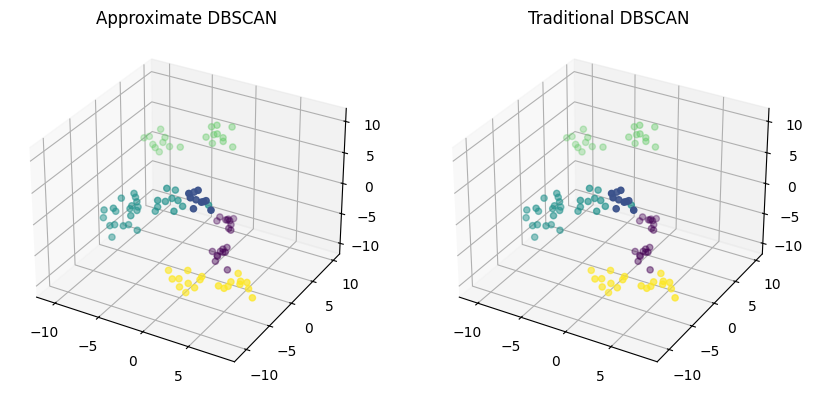

In [3]:
random_result = get_point_cluster_df(random_X, random_adbscan)
random_result['sklearn_cluster'] = sklearn_dbscan(random_X, eps, min_pts)

ari, ami, scoef = evaluate(random_X, random_result['cluster_id'], random_result['sklearn_cluster'])

plot_clustering_points(random_X, random_result, 'random_ApproxDBSCAN.png')


# IRIS

In [4]:
# load iris dataset
iris = datasets.load_iris()
iris_X = iris.data
iris_y = iris.target

eps = 0.5
min_pts = 5
rho = 0.01
n_pa_each_dim = [2, 2, 2, 2]

iris_rdd, n_grid_each_dim = parallelize_data(iris_X, eps, n_pa_each_dim, sc)
iris_rdd.cache()

iris_adbscan = ApproxDBSCAN(iris_rdd, eps, min_pts, rho, n_grid_each_dim, n_pa_each_dim, sc)


/Users/yaozeyi/anaconda3/envs/py310/lib/python3.10/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/Users/yaozeyi/anaconda3/envs/py310/lib/python3.10/site-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


ARI: 0.6334
AMI: 0.6604
Silhouette Coefficient: 0.4860


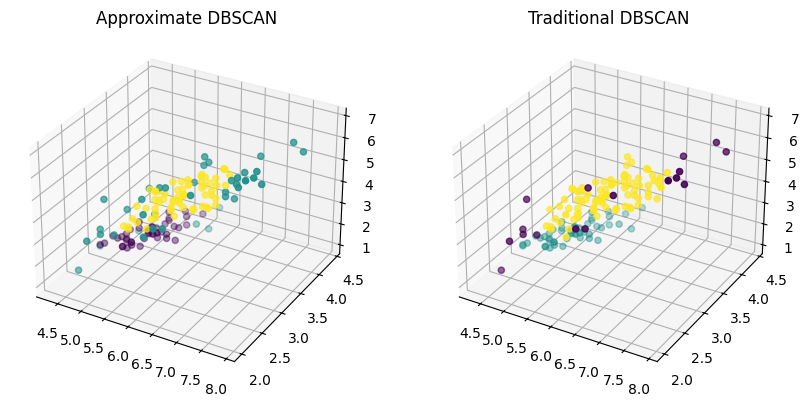

In [5]:
iris_result = get_point_cluster_df(iris_X, iris_adbscan)
iris_result['sklearn_cluster'] = sklearn_dbscan(iris_X, eps, min_pts)

evaluate(iris_X, iris_result['cluster_id'], iris_result['sklearn_cluster'])

plot_clustering_points(iris_X, iris_result, 'IRIS_ApproxDBSCAN')